In [1]:
# Path for the dataset
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images' 
class_labels = ['Parasitized', 'Uninfected']

# Controlling Parameters
img_height = 128
img_width = 128
epochs = 20
batch_size = 32
train_split = 0.8

# Data Loading

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=1 - train_split  # Validation split
)

# ImageDataGenerator for validation (without augmentation)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=1 - train_split
)

# Load the training data with augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    classes=class_labels
)

# Load the validation data without augmentation
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    classes=class_labels
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


# Data Analysis

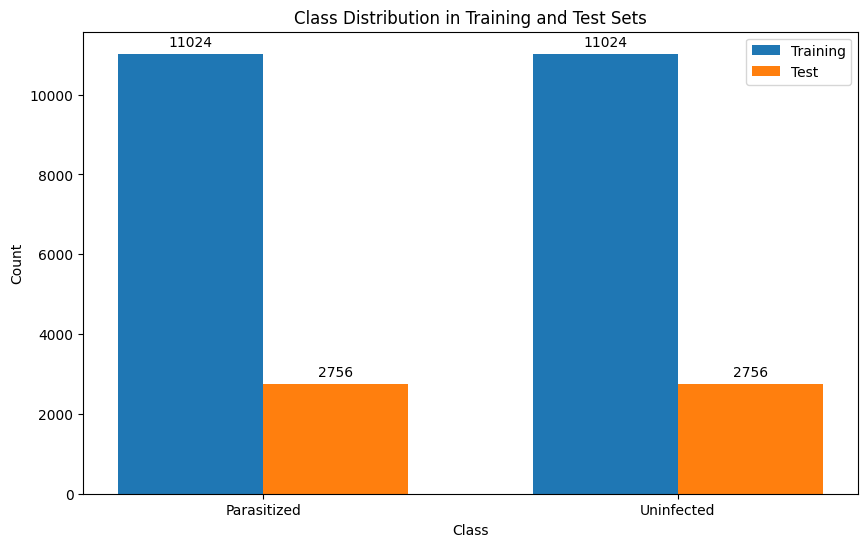

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

class_dirs = [os.path.join(data_dir, class_name) for class_name in ['Parasitized', 'Uninfected']]

# Count files in each class folder for the training and test sets
train_split = 0.8
train_counts = []
test_counts = []

for class_dir in class_dirs:
    total_count = len(os.listdir(class_dir))
    train_count = int(total_count * train_split)
    test_count = total_count - train_count
    train_counts.append(train_count)
    test_counts.append(test_count)

# Plotting the class distribution
x = np.arange(len(class_labels))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Training')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

# Adding labels, title, and customizing ticks
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Training and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

# Adding data labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.show()

In [4]:
from PIL import Image
import cv2

# Initialize dictionaries to store sizes and pixel intensities
image_data = {'Parasitized': {'sizes': [], 'pixel_intensities': []},
              'Uninfected': {'sizes': [], 'pixel_intensities': []}}

# Iterate through the dataset once
for class_name in class_labels:
    class_path = os.path.join(data_dir, class_name) # Folder Path
    for img_name in os.listdir(class_path)[:1000]:
        if img_name.endswith(".png"):  # Ensure only .png files are processed
            img_path = os.path.join(class_path, img_name)

            # Get image size using PIL
            img = Image.open(img_path)
            image_data[class_name]['sizes'].append(img.size)

            # Get pixel intensities using OpenCV
            img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            image_data[class_name]['pixel_intensities'].extend(img_cv.flatten())

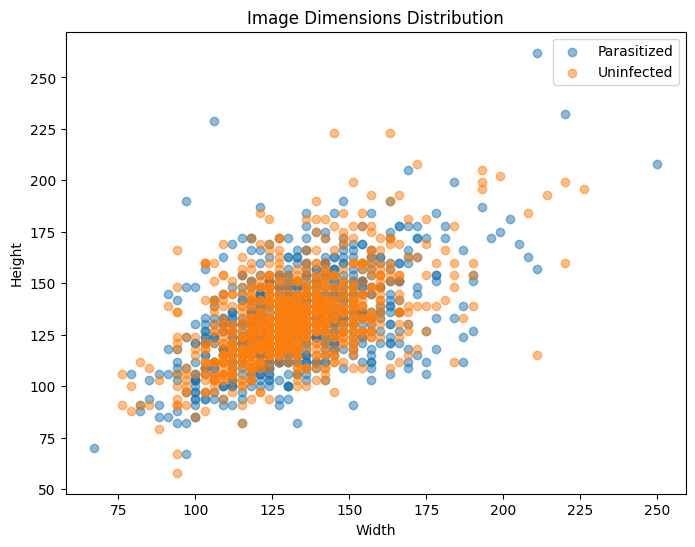

In [5]:
# Plot the image dimensions distribution
plt.figure(figsize=(8, 6))
for class_name, data in image_data.items():
    widths, heights = zip(*data['sizes'])
    plt.scatter(widths, heights, alpha=0.5, label=class_name)
plt.title('Image Dimensions Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()

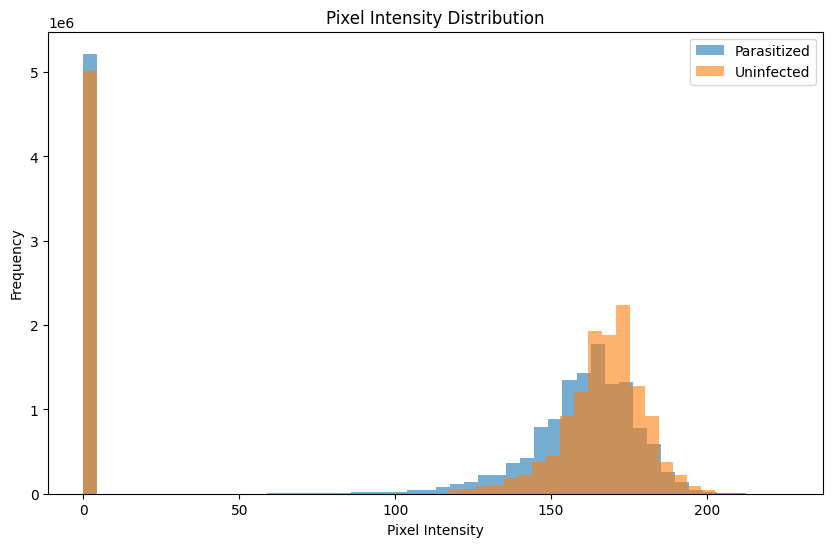

In [6]:
# Plot the pixel intensity distribution
plt.figure(figsize=(10, 6))
for class_name, data in image_data.items():
    plt.hist(data['pixel_intensities'], bins=50, alpha=0.6, label=class_name)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

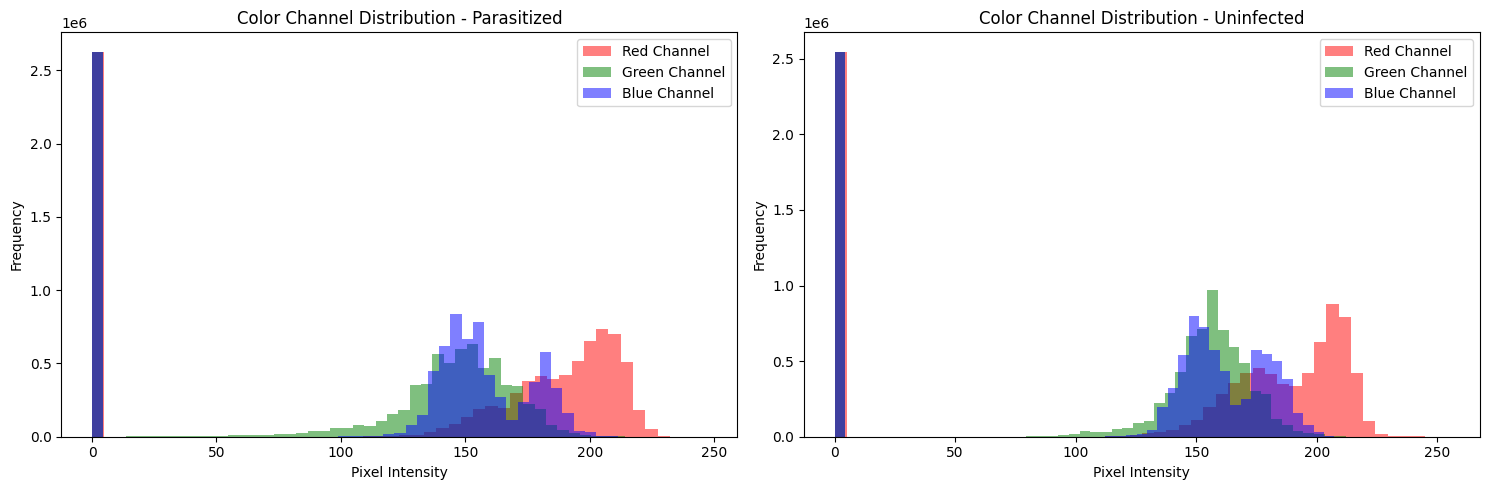

In [7]:
color_channels = {'Parasitized': {'R': [], 'G': [], 'B': []}, 
                  'Uninfected': {'R': [], 'G': [], 'B': []}}

for class_name in class_labels:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path)[:500]:
        if img_name.endswith(".png"):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            color_channels[class_name]['R'].extend(img[:, :, 2].flatten())
            color_channels[class_name]['G'].extend(img[:, :, 1].flatten())
            color_channels[class_name]['B'].extend(img[:, :, 0].flatten())

# Plot the RGB distributions
plt.figure(figsize=(15, 5))
for i, (class_name, channels) in enumerate(color_channels.items()):
    plt.subplot(1, 2, i + 1)
    plt.hist(channels['R'], bins=50, alpha=0.5, color='red', label='Red Channel')
    plt.hist(channels['G'], bins=50, alpha=0.5, color='green', label='Green Channel')
    plt.hist(channels['B'], bins=50, alpha=0.5, color='blue', label='Blue Channel')
    plt.title(f'Color Channel Distribution - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


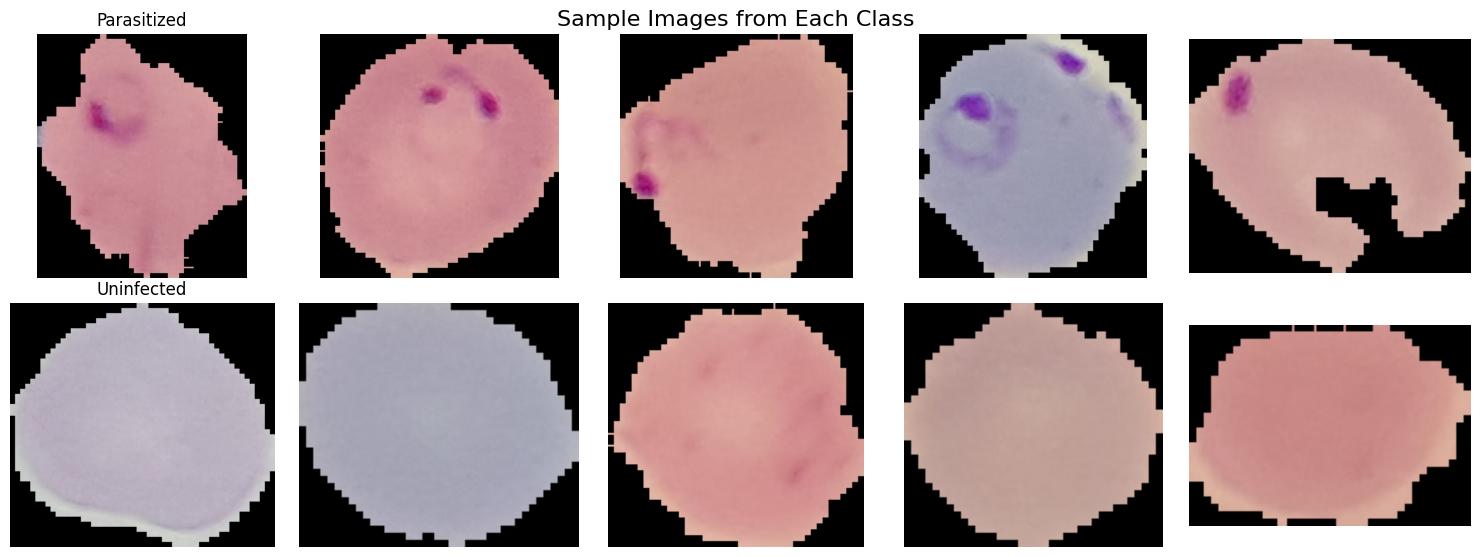

In [8]:
def plot_class_samples(data_dir, class_labels, num_samples=5):

    fig, axes = plt.subplots(len(class_labels), num_samples, figsize=(15, len(class_labels) * 3))
    fig.suptitle("Sample Images from Each Class", fontsize=16, y=0.92)

    for i, class_name in enumerate(class_labels):
        class_path = os.path.join(data_dir, class_name)
        # Get all image files from the class directory
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            image = Image.open(img_path)

            # Plot the image
            ax = axes[i, j] if len(class_labels) > 1 else axes[j]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(class_name if j == 0 else "")
    
    plt.tight_layout()
    plt.show()

plot_class_samples(data_dir, class_labels, num_samples=5)

# CNN Modeling

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Display the model architecture
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

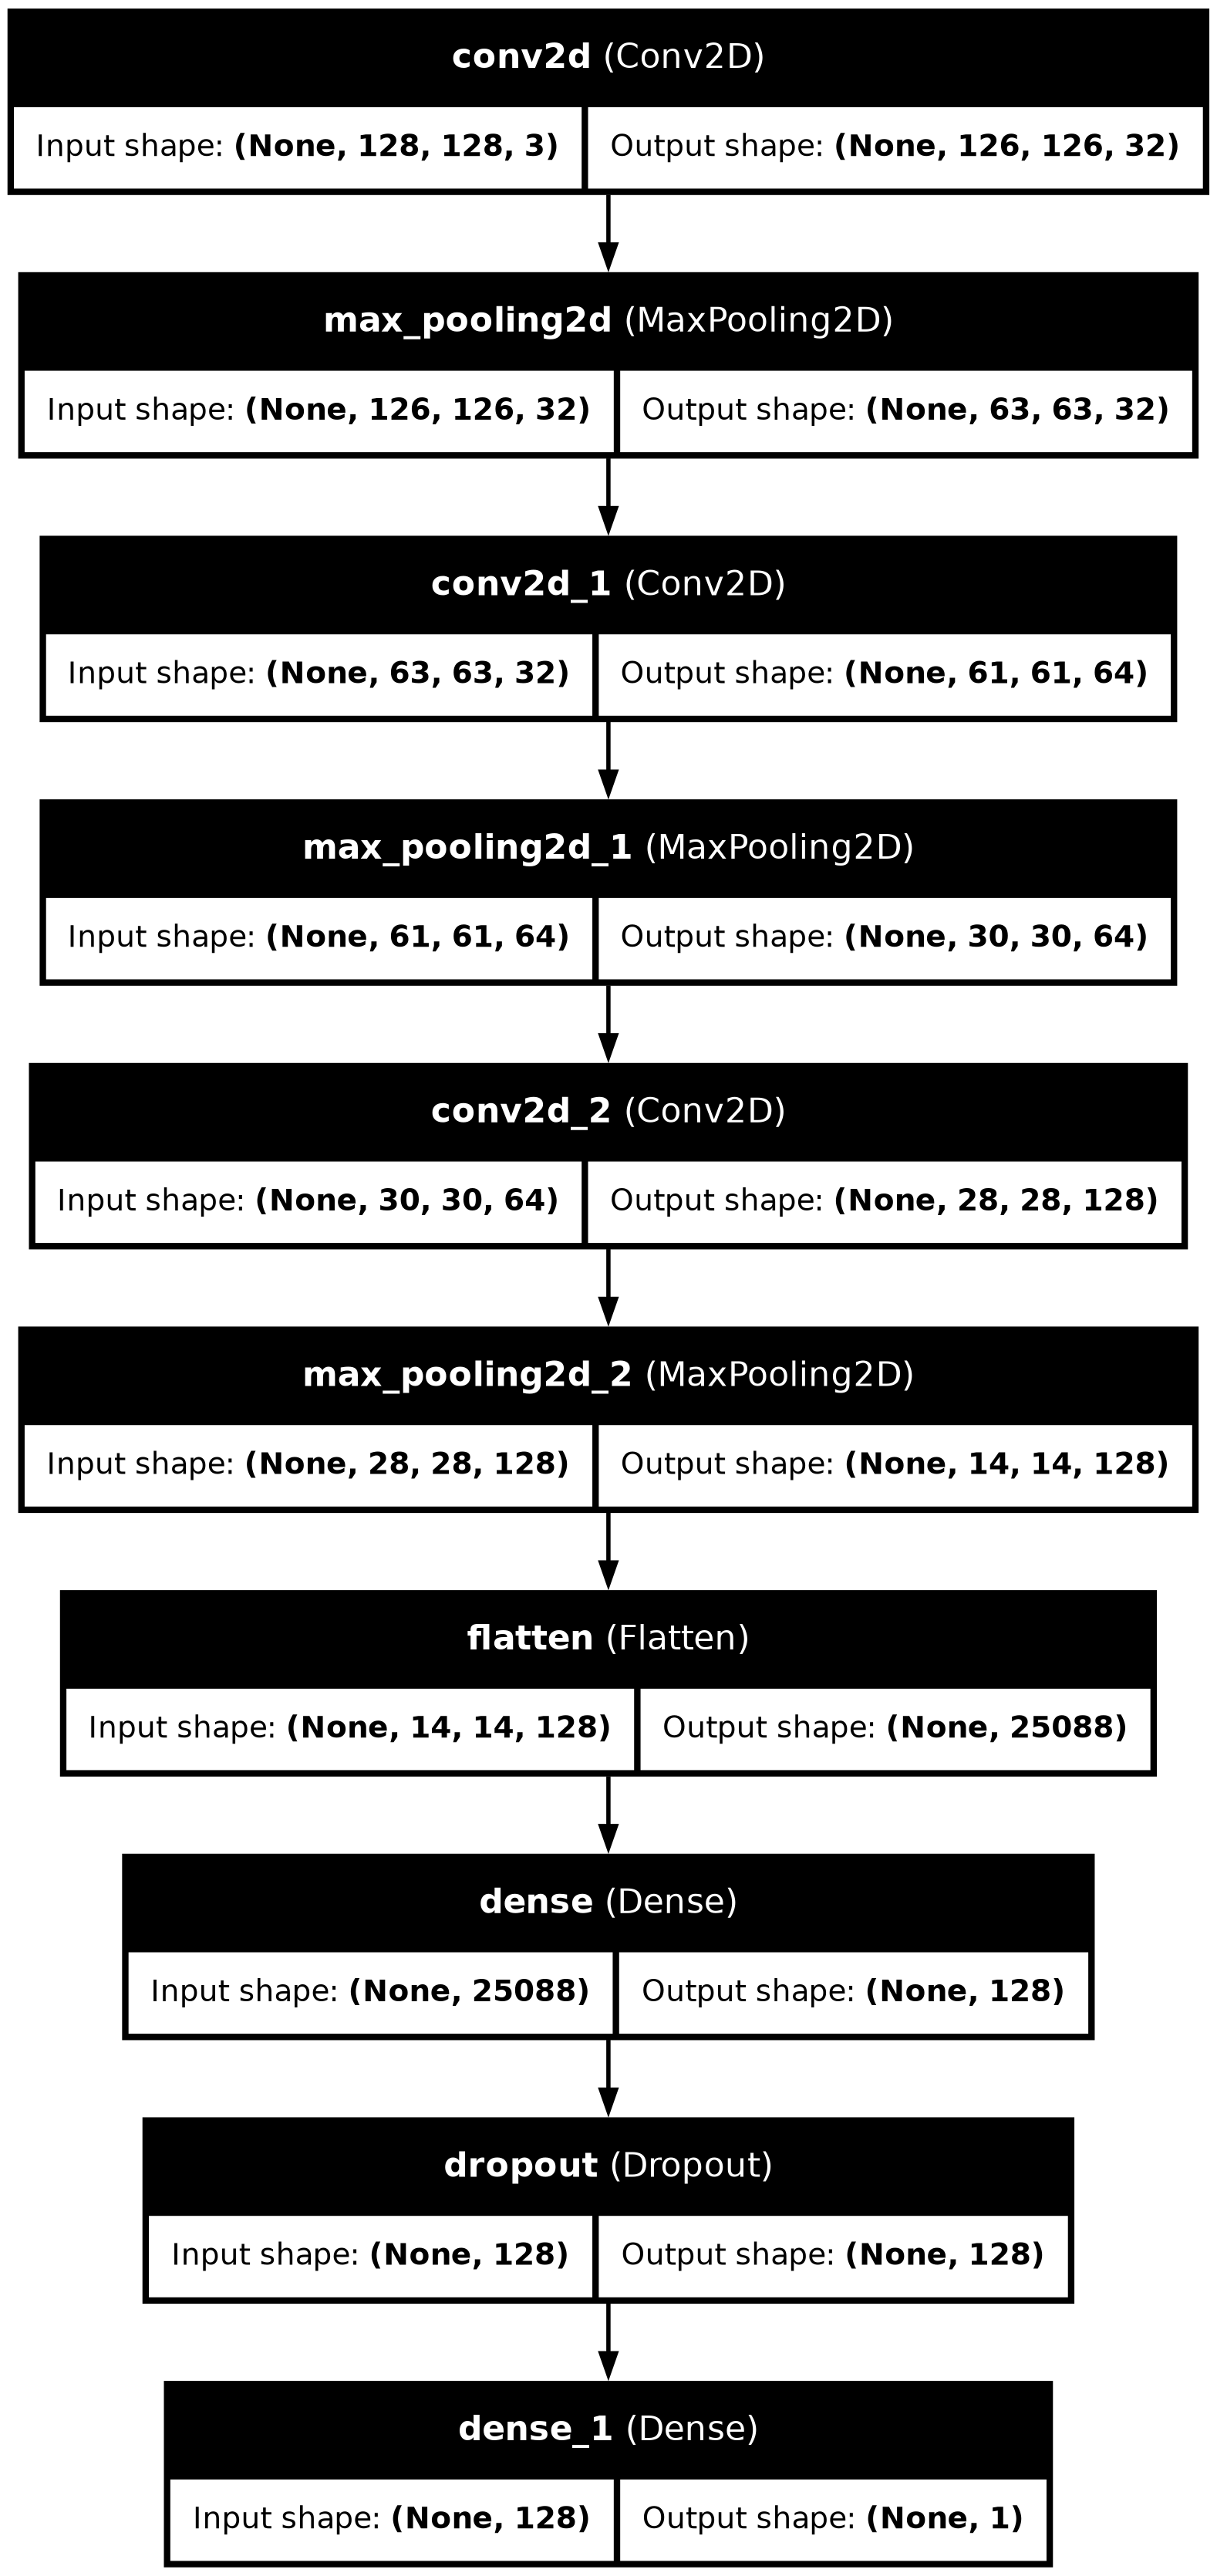

In [10]:
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture
plot_model(
    model,
    to_file='cnn_model_architecture.png',  # Saves the plot as a PNG file
    show_shapes=True,                      # Displays the shape of each layer's output
    show_layer_names=True,                 # Displays the layer names
    expand_nested=False                    # Expands nested layers (if any)
)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Path to save the best model
checkpoint_path = "best_model_cnn.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    mode='min',                # Mode to minimize val_loss
    save_best_only=True,       # Save only the best model
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [12]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734163954.831281      81 service.cc:145] XLA service 0x7b5fc0006b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734163954.831335      81 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/689 ━━━━━━━━━━━━━━━━━━━━ 1:22:40 7s/step - accuracy: 0.5938 - loss: 0.6931

I0000 00:00:1734163958.851693      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7113 - loss: 0.5521
Epoch 1: val_loss improved from inf to 0.20350, saving model to best_model_cnn.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 183s 255ms/step - accuracy: 0.7118 - loss: 0.5514 - val_accuracy: 0.9434 - val_loss: 0.2035
Epoch 2/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9381 - loss: 0.2002
Epoch 2: val_loss improved from 0.20350 to 0.19048, saving model to best_model_cnn.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 113s 162ms/step - accuracy: 0.9382 - loss: 0.2002 - val_accuracy: 0.9377 - val_loss: 0.1905
Epoch 3/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9442 - loss: 0.1757
Epoch 3: val_loss did not improve from 0.19048
689/689 ━━━━━━━━━━━━━━━━━━━━ 111s 159ms/step - accuracy: 0.9442 - loss: 0.1757 - val_accuracy: 0.9419 - val_loss: 0.2028
Epoch 4/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9490 - loss: 0.1708
Epoch 4: val_loss improved from 0.19048 to 0.16144, saving model to best_mo

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_model(y_true, y_pred, class_names, history):
    # Convert predicted probabilities to binary values
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Plot training & validation accuracy and loss values
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", classification_report(y_true, y_pred_binary, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step


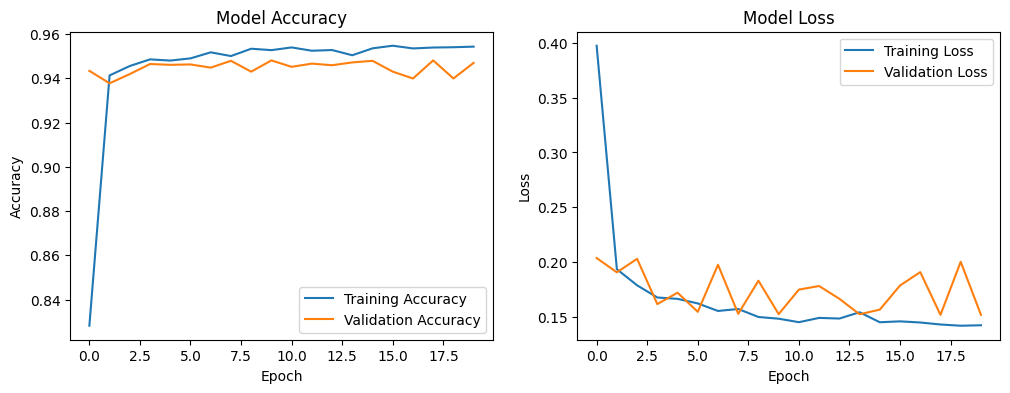

Accuracy: 0.947005444646098
Precision: 0.9331691874780161
Recall: 0.9629764065335753
F1 Score: 0.9478385137549125

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.96      0.93      0.95      2755
  Uninfected       0.93      0.96      0.95      2755

    accuracy                           0.95      5510
   macro avg       0.95      0.95      0.95      5510
weighted avg       0.95      0.95      0.95      5510



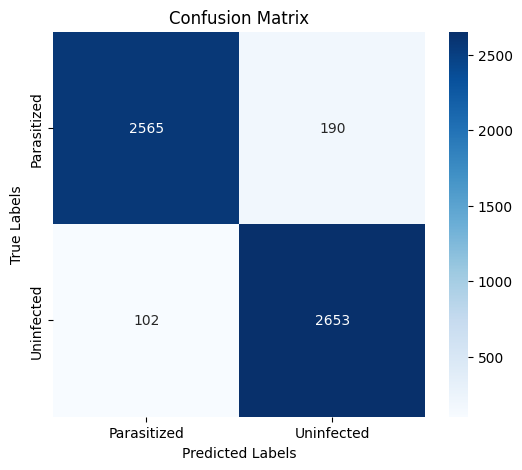

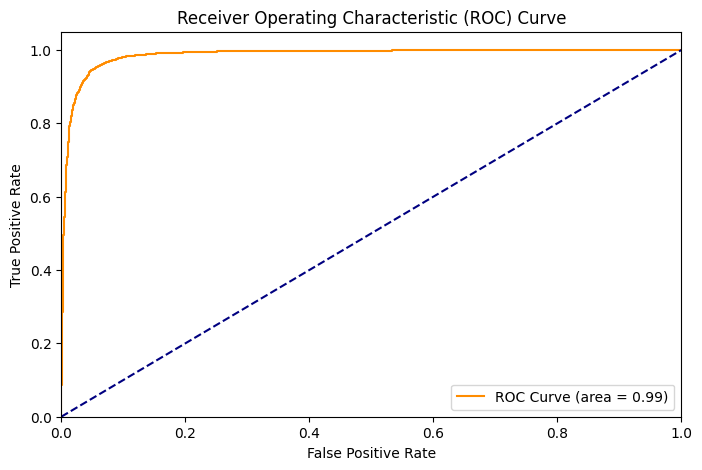

In [14]:
test_generator.reset()
y_true = test_generator.classes  # Ground truth labels
y_pred = model.predict(test_generator)  # Predicted probabilities

class_names = list(test_generator.class_indices.keys())
evaluate_model(y_true, y_pred, class_names, history)

# Transfer Learning Model

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load the MobileNetV2 model without the top layer (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),       # Pool the features
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),                   # Dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Display model architecture
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Path to save the best model
checkpoint_path = "best_model_TL.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [17]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks
)

Epoch 1/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8371 - loss: 0.3768
Epoch 1: val_loss improved from inf to 0.24733, saving model to best_model_TL.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 130s 174ms/step - accuracy: 0.8373 - loss: 0.3765 - val_accuracy: 0.9018 - val_loss: 0.2473
Epoch 2/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8940 - loss: 0.2648
Epoch 2: val_loss did not improve from 0.24733
689/689 ━━━━━━━━━━━━━━━━━━━━ 113s 162ms/step - accuracy: 0.8940 - loss: 0.2647 - val_accuracy: 0.9004 - val_loss: 0.2580
Epoch 3/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9059 - loss: 0.2481
Epoch 3: val_loss did not improve from 0.24733
689/689 ━━━━━━━━━━━━━━━━━━━━ 113s 162ms/step - accuracy: 0.9059 - loss: 0.2481 - val_accuracy: 0.9031 - val_loss: 0.2670
Epoch 4/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9087 - loss: 0.2387
Epoch 4: val_loss did not improve from 0.24733
689/689 ━━━━━━━━━━━━━━━━━━━━ 114s 164ms/step - accuracy: 0.9

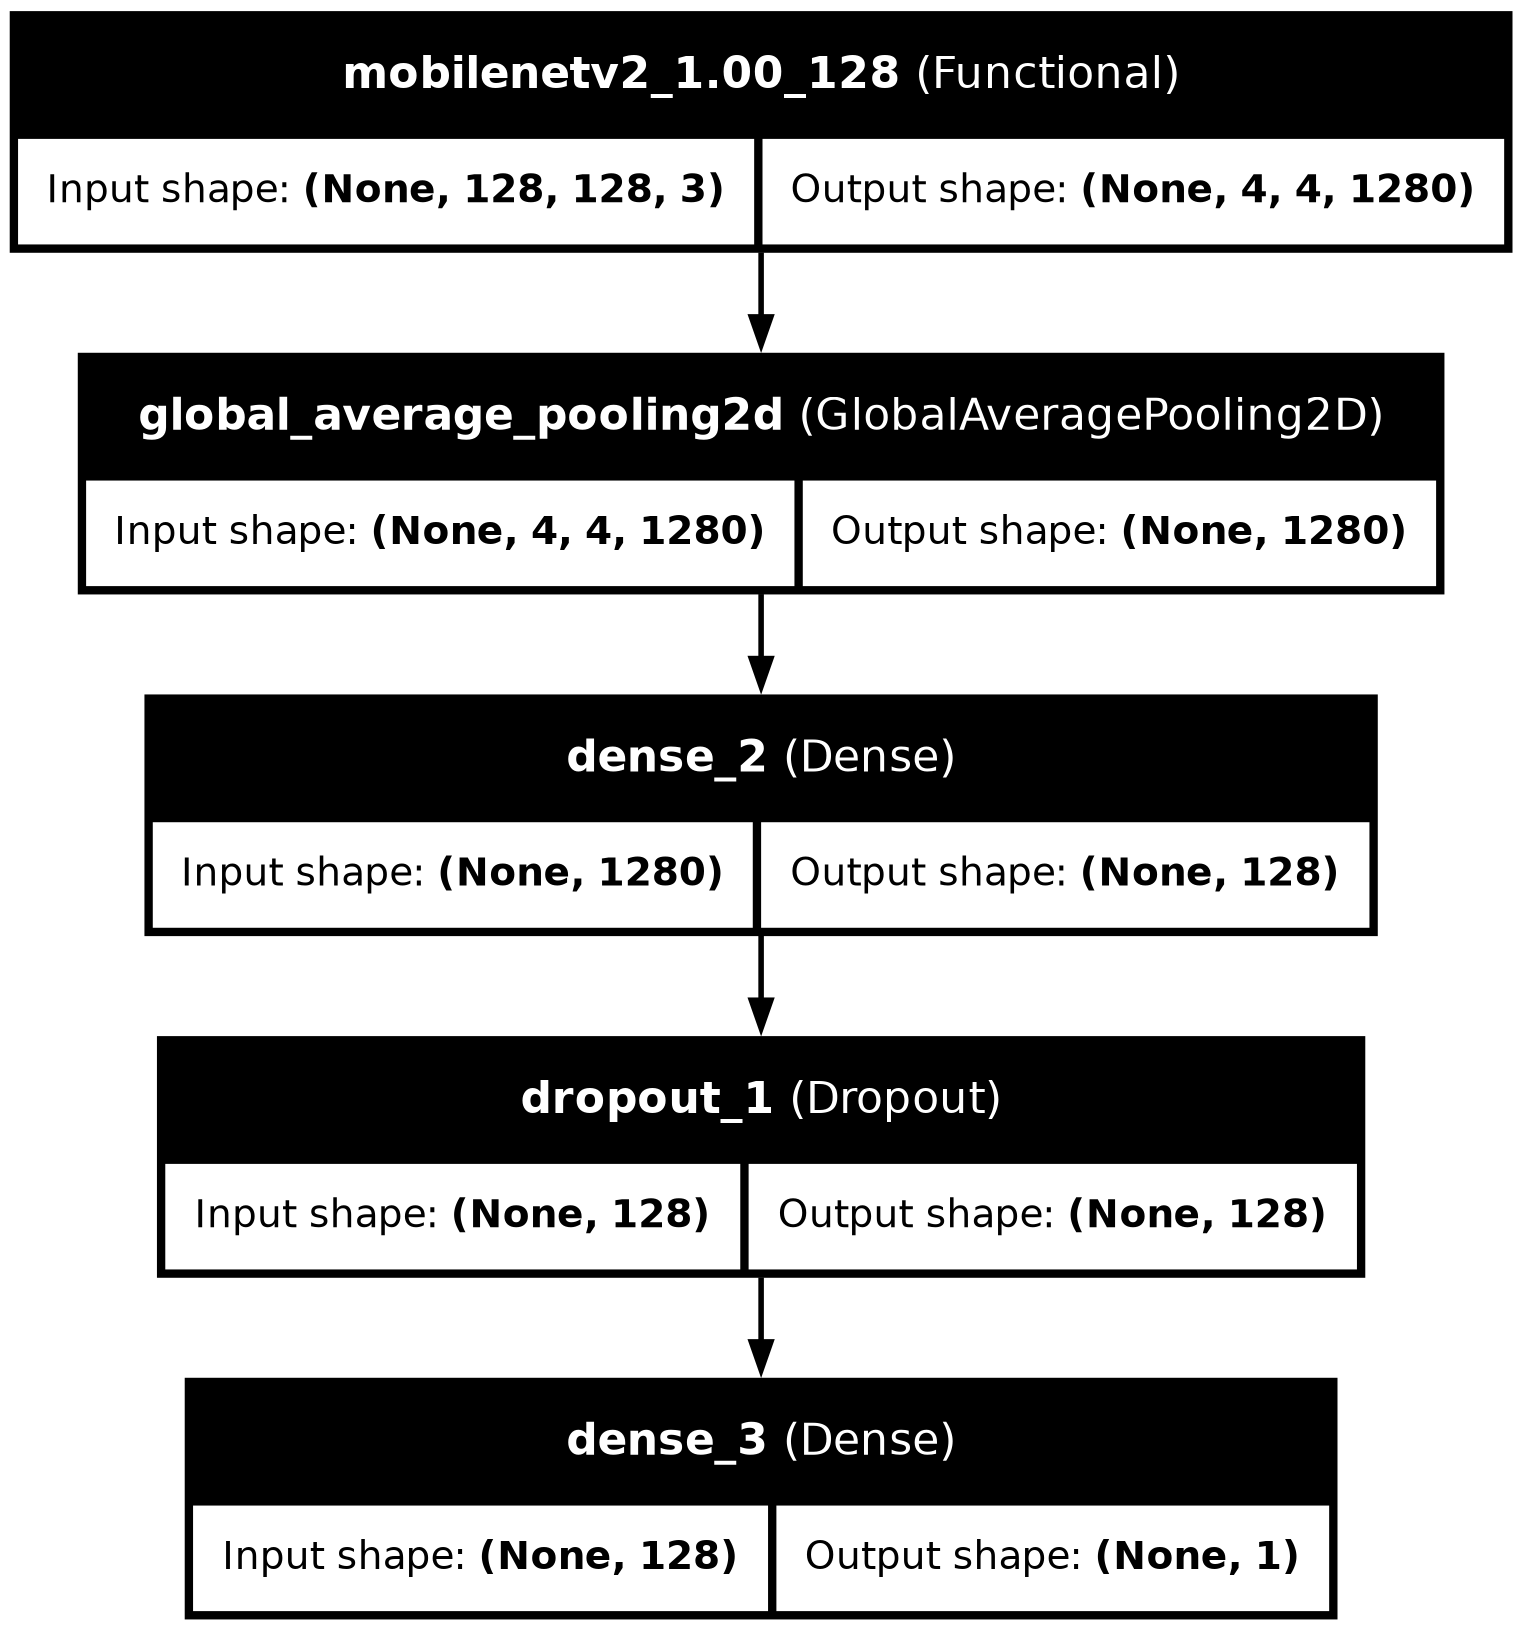

In [18]:
# Plot and save the model architecture
plot_model(
    model,
    to_file='cnn_model_architecture.png',  # Saves the plot as a PNG file
    show_shapes=True,                      # Displays the shape of each layer's output
    show_layer_names=True,                 # Displays the layer names
    expand_nested=False                    # Expands nested layers (if any)
)

173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step


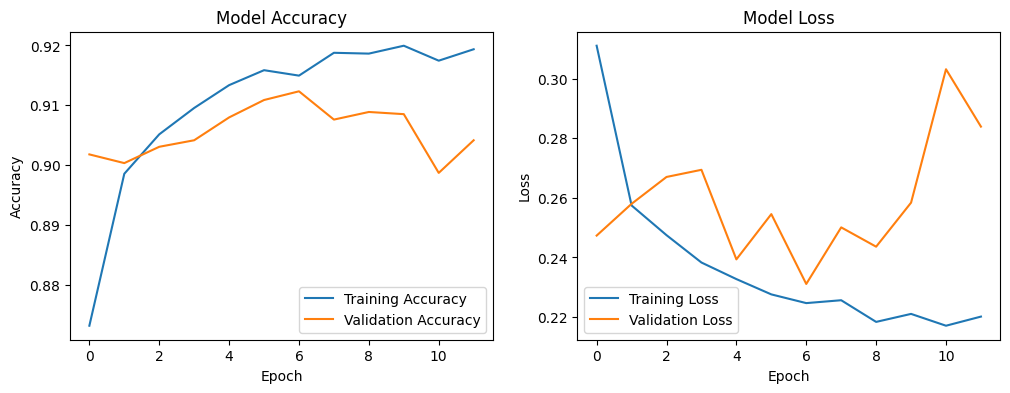

Accuracy: 0.9041742286751361
Precision: 0.8560921010553246
Recall: 0.9716878402903811
F1 Score: 0.9102346140768446

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.97      0.84      0.90      2755
  Uninfected       0.86      0.97      0.91      2755

    accuracy                           0.90      5510
   macro avg       0.91      0.90      0.90      5510
weighted avg       0.91      0.90      0.90      5510



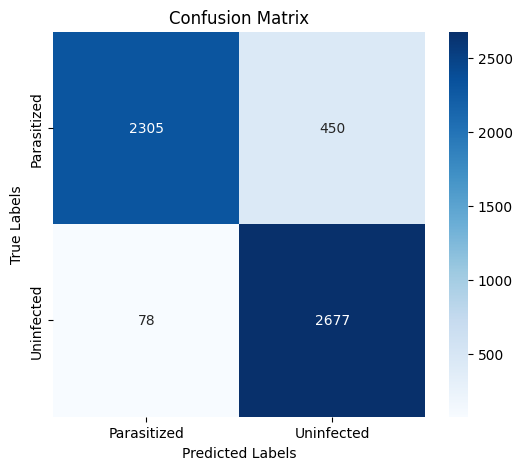

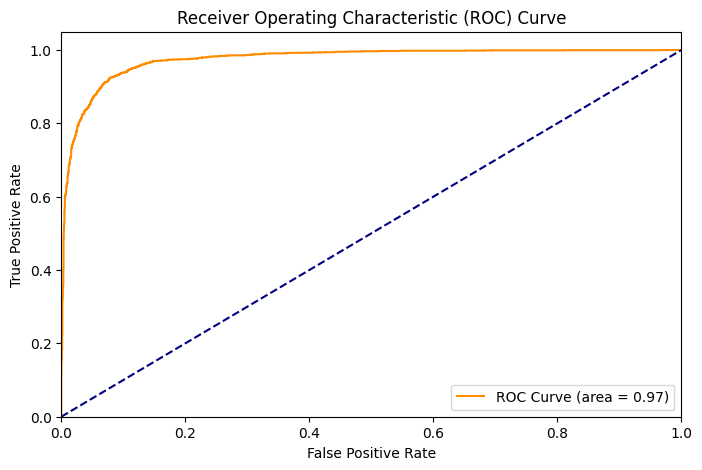

In [19]:
test_generator.reset()
y_true = test_generator.classes         # Ground truth labels
y_pred = model.predict(test_generator)  # Predicted probabilities

class_names = list(test_generator.class_indices.keys())
evaluate_model(y_true, y_pred, class_names, history)